In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from exact import solve
from policies import FixedPlanPolicy
from mouselab_policy import MouselabPolicy

In [25]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Define environment

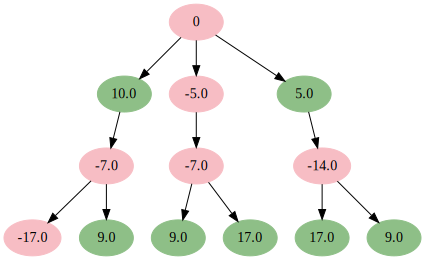

In [26]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=5, branching=[3,1,2], increasing=0, cost=1.00, seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            x = np.array([-2,-1,1,2])
            vals = mu + sigma * x * (depth ** increasing)
            return Categorical(vals).apply(round)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

env = make_env(increasing=0.5, branching=(3,1,2), ground_truth=False)
for n in range(1, len(env.init)):
    env.step(n)
env.render()

In [30]:
master_envs = {sigma: make_env(sigma=sigma, ground_truth=False)
               for sigma in range(1,11)}


# Exact solution

In [28]:
np.log(100) / np.log(10)

2.0

In [33]:
np.log(1.1)

0.09531017980432493

array([ 1.   ,  1.048,  1.099,  1.151,  1.207,  1.265,  1.326,  1.389,  1.456,  1.526,  1.6  ,  1.677,  1.758,  1.842,  1.931,  2.024,  2.121,  2.223,  2.33 ,  2.442,  2.56 ,  2.683,  2.812,  2.947,
        3.089,  3.237,  3.393,  3.556,  3.728,  3.907,  4.095,  4.292,  4.498,  4.715,  4.942,  5.179,  5.429,  5.69 ,  5.964,  6.251,  6.551,  6.866,  7.197,  7.543,  7.906,  8.286,  8.685,  9.103,
        9.541, 10.   ])

In [55]:
log(900), log(800)

(6.802394763324311, 6.684611727667927)

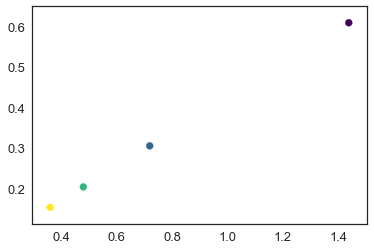

In [52]:
x = np.linspace(1, 100, 100)
dx = x[1] - x[0]

def simulate(base=np.e):
    y = np.log(x) / np.log(base)
    dydx = np.diff(y) / dx
    return {'base': base, 'low': dydx[20:40].mean(), 'high': dydx[60:80].mean()}

dd = pd.DataFrame(simulate(b) for b in np.logspace(0, 1, 100)[1:5])
plt.scatter(dd.low, dd.high, c=dd.base, cmap='viridis')

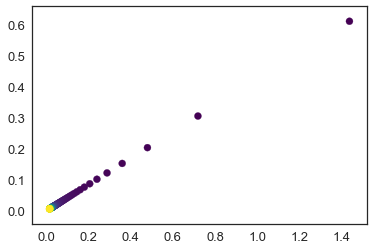

(0, 1.1)

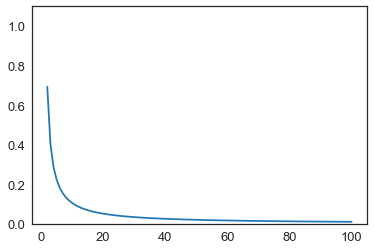

In [17]:
x = np.linspace(1, 100, 100)
dx = x[1] - x[0]
y = np.log(x)
dydx = np.diff(y) / dx
plt.plot(x[1:], dydx)
plt.ylim(0,1.1)

In [ ]:
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_x12)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)

optimal_policies = {sigma: get_optimal_policy(env)
                    for sigma, env in master_envs.items()}
# optimal_policy = get_optimal_policy(env)
# Q = optimal_policy.preference

In [31]:
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_x12)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)

optimal_policies = {sigma: get_optimal_policy(env)
                    for sigma, env in master_envs.items()}
# optimal_policy = get_optimal_policy(env)
# Q = optimal_policy.preference

0.0
1.257415771484375
3.4904677271842957
6.074667930603027
8.879117548465729
11.792245745658875
14.761354565620422
17.756556034088135
20.76282376050949
23.771464228630066


# Simulations

In [34]:
from evaluation import evaluate
def simulate():
    for sigma, env in master_envs.items():
        df = evaluate(optimal_policies[sigma], [env] * 100)
        df['sigma'] = sigma
        yield df
        
df = pd.concat(simulate())

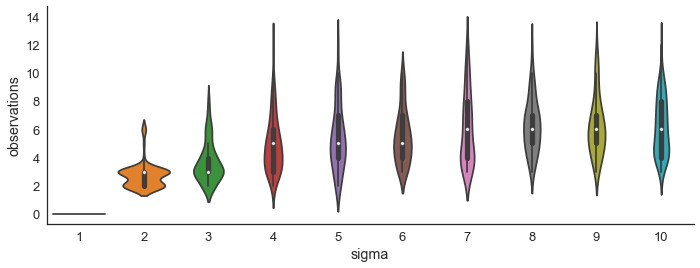

In [41]:
sns.factorplot('sigma', 'observations', data=df, kind='violin', aspect=2.5)

In [58]:
sep = [(sigma, env, optimal_policies[sigma]) 
       for sigma, env in master_envs.items()]

In [63]:
SEED = 148
np.random.seed(SEED)
from agents import run_episode
from toolz import get

def simulate(repeat=1):
    for sigma, env, policy in sep:
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'cost': abs(env.cost), 'env_id': hash(env),
                       'state': s, 'action': a, 'reward': r, 'sigma': sigma}

                
df = pd.DataFrame(simulate(1000))

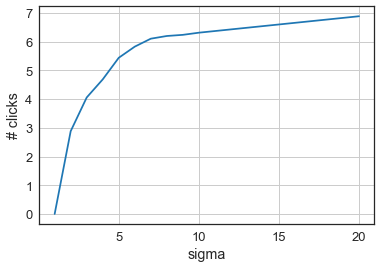

In [70]:
n_click = (df.groupby('sigma').apply(len) - 1000) / 1000
n_click.plot()
plt.grid()
plt.ylabel('# clicks')

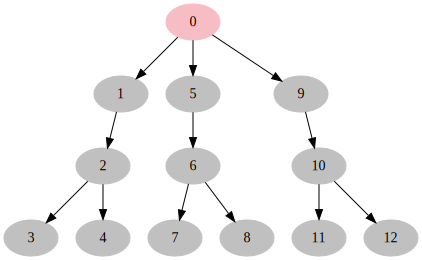

In [56]:
env.reset()
env.render()

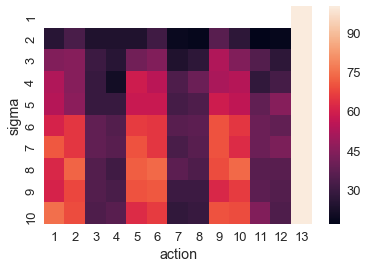

In [54]:
sns.heatmap(df.groupby('sigma').action.value_counts().unstack())

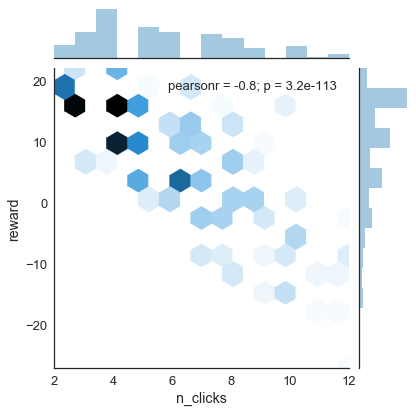

In [58]:
returns = df.groupby('env_id').reward.sum()
n_clicks = df.groupby('env_id').apply(len) - 1
g = sns.jointplot(n_clicks, returns, kind='hex')
g.ax_joint.set_xlabel('n_clicks')

full       3.330
optimal    8.552
random     3.676
dtype: float64


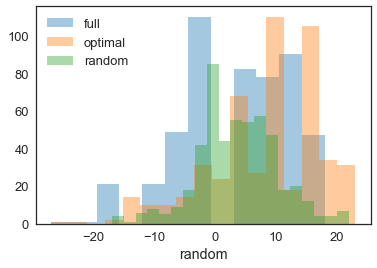

In [59]:
def pol_returns(envs):
    return pd.DataFrame({
        'optimal': get_util(optimal_policy, envs, return_mean=0),
        'random': get_util(MouselabPolicy({'term_reward': 0}), envs, return_mean=0),
        'full': get_util(FixedPlanPolicy(range(1, env.term_action+1)), envs, return_mean=0),
    })

dd = pol_returns(envs)
for k, v in dd.items():
    sns.distplot(v, label=k, kde=0)
plt.legend()
print(dd.mean())

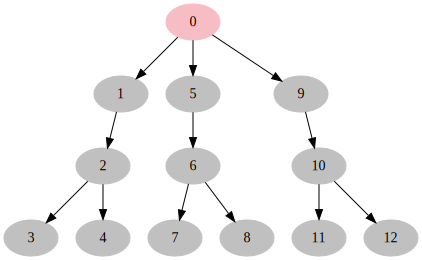

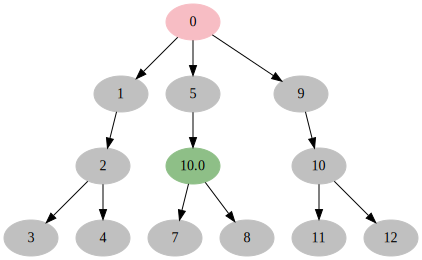

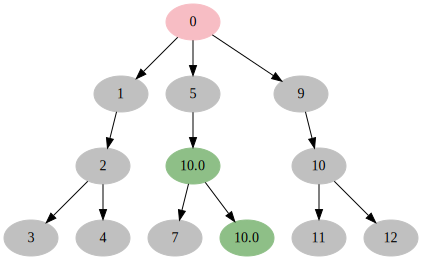

In [61]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

# Save environments to JSON files

In [ ]:
import json
def demo(env):
    trace = run_episode(optimal_policy, env)
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
        'demo': {
            'clicks': trace['actions'][:-1],
            'path': next(env.optimal_paths(trace['states'][-1]))[1:]
        }

    }

nr_environments = 10
branch = [3,1,2]
envs = [make_env() for _ in range(nr_environments)]

fn = '../experiment/experiment/static/json/demo.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(demo, envs)), f)

In [80]:
np.random.seed(1)

import json
def env_data(env):
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),

    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]
env_type = ''.join(map(str, branch))
envs = [make_env(mu=0, sigma=5, quantization=4, branching=branch)
        for _ in range(nr_environments)]

# fn = 'data/experiment_trials/'+env_type+'.json'
fn = 
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

wrote data/experiment_trials/312.json


In [70]:
%%bash
# This updates the trials for the experiment. Be careful!
cp data/experiment_trials/* ../experiment/experiment/static/json/rewards/

In [74]:
from functools import wraps
from toolz import curry

def observed(state, node):
    return not hasattr(state[node], 'sample')

@curry
def satisfruning(preference, prune=None, satisfice=None, env=env):
    @wraps(preference)
    def new_pref(state, action, prune=prune, satisfice=satisfice):
        if action == env.term_action:
            if satisfice is not None:
                satisfied = env.expected_term_reward(state) >= satisfice
                return 1e10 if satisfied else -1e10
        elif prune is not None:
            if env.node_quality(action, state).expectation() <= prune:
                return -1e20
        return preference(state, action)
    
    return new_pref

In [75]:
def depth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are further from the start
    return len(previous_nodes)

In [ ]:
path_values = range(-30, 31, 5)
defaults = {
    'p_error': np.linspace(0.01,1, 50),
    'satisfice': [v for v in path_values if v >= 0],
    'prune': [v for v in path_values if v <= 0],
    'temp': np.logspace(-5,1, 50),
}

In [76]:
def eval_satisfruning(sigma, n=10):
    envs = [make_env(sigma=sigma) for _ in range(n)]
    for s in [v for v in path_values if v >= 0]:
        for p in [v for v in path_values if v <= 0]:
            pol = SoftmaxPolicy(satisfruning(depth_first, prune=p, satisfice=s)
            get_util(pol, envs)

{1: <mouselab.MouselabEnv at 0x169cd09e8>,
 2: <mouselab.MouselabEnv at 0x169cd5b38>,
 3: <mouselab.MouselabEnv at 0x169cd5b70>,
 4: <mouselab.MouselabEnv at 0x169ea1780>,
 5: <mouselab.MouselabEnv at 0x169e99438>,
 6: <mouselab.MouselabEnv at 0x169eb6f98>,
 7: <mouselab.MouselabEnv at 0x169eb6d68>,
 8: <mouselab.MouselabEnv at 0x169e849e8>,
 9: <mouselab.MouselabEnv at 0x169dd1b38>,
 10: <mouselab.MouselabEnv at 0x169dd1320>,
 20: <mouselab.MouselabEnv at 0x3a55b4fd0>}